In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import warnings
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.metrics.pairwise import pairwise_distances
from matplotlib import pyplot as plt
from scipy.spatial.distance import pdist, squareform
import pandas as pd
warnings.filterwarnings('ignore')
sns.set()

ModuleNotFoundError: No module named 'mlxtend'

In [ ]:
data = pd.read_excel('Data.xls', sheet_name = ['POS DATA'])
df_raw = data['POS DATA']
df_raw.head()

In [ ]:
print(df_raw.shape)

In [ ]:
df_raw.Description.unique()

In [ ]:
df_raw = df_raw[~ df_raw.Description.isin(['CFLs,cfls,7832553,2,0\r\n7831582,Channa Dal,channa-dal,7832491,2,0\r\n7832360,Cheese,cheese,7832363,2,0\r\n7831689,Chewing Gum,chewing-gum,7831685,2,0\r\n7832047,ChildrenS Books'])]
df_raw.head()

In [ ]:
df_f = df_raw.copy()

In [ ]:
df_raw['Created On']=pd.to_datetime(df_raw['Created On'])
df_raw['Year'] = df_raw['Created On'].dt.year
df_raw['Month'] = df_raw['Created On'].dt.month
df_raw['Day'] = df_raw['Created On'].dt.day
df_raw['Time'] = df_raw['Created On'].dt.time
df_raw['Day of Week'] = df_raw['Created On'].dt.day_name()
df_raw.head()

In [ ]:
df_raw.Year.unique()

In [ ]:
df_raw_items = df_raw[df_raw['Year'].isin([2014,2013])]
df_raw_items = df_raw.groupby(['Description'])['Member'].count().reset_index()
df_raw_items = df_raw_items.sort_values(by = 'Member', ascending = False)
df_raw_items = df_raw_items.head(10)
top_items = df_raw_items['Description'].tolist()
top_items

In [ ]:
df_raw_day = df_raw[(df_raw['Year'].isin([2014,2013])) & (df_raw['Description'].isin(top_items))]
df_raw_day = df_raw_day.groupby(['Day of Week','Description'])['Member'].count().reset_index()
df_raw_day

In [ ]:
grouped_data = df_raw_day.groupby('Description')['Member'].sum()
sorted_grouped_data = grouped_data.sort_values(ascending=False)
plt.figure(figsize=(10, 6))
bars = plt.bar(sorted_grouped_data.index, sorted_grouped_data.values)
plt.xlabel('Description')
plt.ylabel('Count')
plt.title('Sales by Description in Descending Order')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




*   The above graph presents the top 10 items sold across 2013-2014
*   We see that Other Vegetables, Root Vegetables and Beans have the highest sales throughout 2013 and 2014
*   Now we will be focusing on day wise sales for a better understanding





In [ ]:
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_raw_day['Day of Week'] = pd.Categorical(df_raw_day['Day of Week'], categories=day_order, ordered=True)
df_raw_day = df_raw_day.sort_values(['Day of Week', 'Description'], ascending=[True, False])

days = df_raw_day['Day of Week'].unique()
n_subplots = len(days)

n_cols = 2
n_rows = n_subplots // n_cols + (n_subplots % n_cols > 0)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 6*n_rows))

axs = axs.flatten()

colors = plt.cm.viridis(np.linspace(0, 1, len(df_raw_day['Description'].unique())))

for i, day in enumerate(days):
    df_day = df_raw_day[df_raw_day['Day of Week'] == day]

    color_map = {desc: colors[j] for j, desc in enumerate(df_day['Description'].unique())}
    bar_colors = df_day['Description'].map(color_map)

    axs[i].bar(df_day['Description'], df_day['Member'], color=bar_colors)
    axs[i].set_title(day)
    axs[i].set_ylabel('Members')
    axs[i].set_xlabel('Description')
    for label in axs[i].get_xticklabels():
        label.set_rotation(45)
        label.set_horizontalalignment('right')

for ax in axs[n_subplots:]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()



*   "Root Vegetables" is a top-selling item with the highest sales consistently across the week.
*   Sales for "Beans" and other items show variability but generally have a moderate sales volume.
*   The color-coded bar charts enable easy tracking of sales trends for each item across different days.
*   Curd & Cucumber shows the maximum variation in sales throughout the week, signaling a fluctuating demand that might be influenced by external factors such as weekly specials, seasonal availability, or shopping habits.
*   The visual data suggests key insights for inventory management and could inform targeted marketing efforts for days with lower sales.












In [2]:
total_orders_per_member = df_raw.groupby('Member')['Member'].count()
top_10_members = total_orders_per_member.sort_values(ascending=False).head(10).index
df_top_10_members = df_raw[df_raw['Member'].isin(top_10_members)]
orders_per_year_member = df_top_10_members.groupby(['Year', 'Member']).size()
orders_per_year_member = orders_per_year_member.reset_index(name='Orders')
orders_per_year_member.columns = ['Year', 'Member', 'Orders']
orders_per_year_member

NameError: name 'df_raw' is not defined

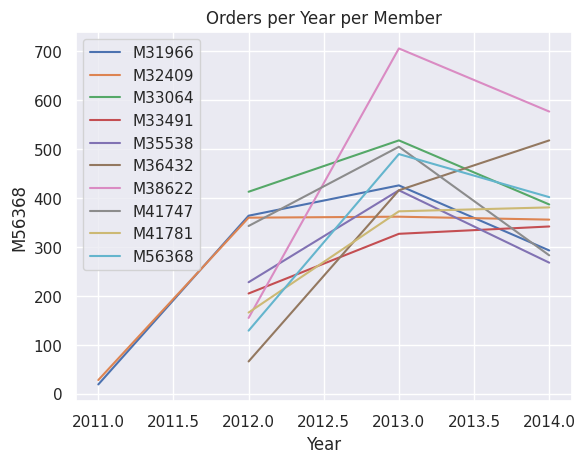

In [14]:
members = orders_per_year_member['Member'].unique()
for member in members:
    member_data = orders_per_year_member[orders_per_year_member['Member'] == member]

    plt.plot(member_data['Year'], member_data['Orders'], label=member)
plt.title('Orders per Year per Member')
plt.xlabel('Year')
plt.ylabel(member)
plt.legend()
plt.show()




*   The above graph contains trend of members who ordered max items throughout 4 years.
*   This graph can be used to analyse trends of how conusmers order and how much items they'll be willing to add.
*   We can see that there are only two members whi have ordered in 2011
*   M38622 placed the highest orders for 2013 and 2014 and should be provided with better recommendations as he is more likely to buy more items.



#Q2

In [15]:
def apriori_recommender(df, member_id, min_support, top):
    df_grouped = df.groupby(['Member', 'Order'])['Description'].agg(list).reset_index()
    df = df_grouped[df_grouped['Member'] == member_id]
    te = TransactionEncoder()
    te_ary = te.fit(df['Description']).transform(df['Description'])
    df = pd.DataFrame(te_ary, columns=te.columns_)
    frequent_itemsets = apriori(df, min_support=min_support, use_colnames=True)
    frequent_itemsets.sort_values(['support'],ascending=False)
    wooden_star_rules = association_rules(frequent_itemsets, metric="lift", min_threshold=.5)
    final_rec = wooden_star_rules.\
    sort_values(['lift','support'],ascending=False).\
    reset_index(drop=True).\
    loc[:,['antecedents','consequents','antecedent support','consequent support','confidence','lift']]
    return final_rec.head(top)

In [16]:
apriori_recommender(df_raw, 'M36432', 0.1, 3)

,antecedents,consequents,antecedent support,consequent support,confidence,lift
0,(Gourd & Cucumber),(Brinjals),0.301980,0.183168,0.409836,2.237483
1,(Brinjals),(Gourd & Cucumber),0.183168,0.301980,0.675676,2.237483
2,(Other Vegetables),(Beans),0.262376,0.193069,0.396226,2.052250


Rule 0 - Gourd & Cucumber → Brinjals:

Antecedent Support (0.301980): About 30.2% of all transactions include Gourd & Cucumber.
Consequent Support (0.183168): About 18.3% of all transactions include Brinjals.
Confidence (0.409836): When Gourd & Cucumber are bought, there's a 41% chance that Brinjals are also bought.
Lift (2.237483): The likelihood of buying Brinjals given that Gourd & Cucumber are bought is 2.24 times the likelihood of buying Brinjals randomly. This suggests a strong association.


Rule 2 - Brinjals → Gourd & Cucumber:

Antecedent Support (0.183168): About 18.3% of all transactions include Brinjals.
Consequent Support (0.301980): About 30.2% of all transactions include Gourd & Cucumber.
Confidence (0.675676): When Brinjals are bought, there's a 67.6% chance that Gourd & Cucumber are also bought.
Lift (2.237483): The likelihood of buying Gourd & Cucumber given that Brinjals are bought is 2.24 times the likelihood of buying Gourd & Cucumber randomly. This indicates a strong relationship, mirroring the first rule but in the reverse direction.


Rule 3 - Beans → Other Vegetables:

Antecedent Support (0.193069): About 19.3% of all transactions include Beans.
Consequent Support (0.262376): About 26.2% of all transactions include Other Vegetables.
Confidence (0.538462): When Beans are bought, there's a 53.8% chance that Other Vegetables are also bought.
Lift (2.052250): The likelihood of buying Other Vegetables given that Beans are bought is 2.05 times the likelihood of buying Other Vegetables randomly, suggesting a significant association.

#Q3

Assumption: HEre we are moving ahead with a combination of content based and colaborative filtering instead of just content based filtering which was given in the bigbasket case study. We used this approach to ensure we have higher amount of data for generating predictions and have an insight for the case as well as

In [17]:
def cosine_missing(df, order_id, top):
    df_grouped = df.groupby(['Order'])['Description'].agg(list).reset_index()
    te = TransactionEncoder()
    te_ary = te.fit_transform(df_grouped['Description'])
    df_te = pd.DataFrame(te_ary, columns=te.columns_)
    cosine_sim = 1 - pairwise_distances(df_te, metric='cosine')
    cosine_sim_df = pd.DataFrame(cosine_sim)
    order_index = df_grouped.index[df_grouped['Order'] == order_id].tolist()[0]
    sorted_indices = cosine_sim_df.iloc[order_index].sort_values(ascending=False).index.tolist()
    top_indices = [idx for idx in sorted_indices if idx != order_index][:5]
    similarity_scores = cosine_sim_df.iloc[order_index][top_indices].values
    basket_items = df_grouped.iloc[order_index]['Description']
    recommended_items_with_scores = [(item, cosine_sim_df.iloc[order_index][idx])
                                     for idx, score in zip(top_indices, similarity_scores)
                                     for item in df_grouped.iloc[idx]['Description']
                                     if item not in basket_items][:top]
    print(f"Top {top} similar orders to order_id {order_id} (by index) are:")
    for idx, score in zip(top_indices, similarity_scores):
        print(f"Similar Order Index: {idx}, Order ID: {df_grouped.iloc[idx]['Order']}, Similarity Score: {score}")
    return recommended_items_with_scores

In [18]:
cosine_missing(df_f, 6468572, 3)

Top 3 similar orders to order_id 6468572 (by index) are:
Similar Order Index: 791, Order ID: 6687487, Similarity Score: 0.5962847939999438
Similar Order Index: 360, Order ID: 6549521, Similarity Score: 0.5962847939999438
Similar Order Index: 5786, Order ID: 7897662, Similarity Score: 0.5773502691896258
Similar Order Index: 854, Order ID: 6704782, Similarity Score: 0.5555555555555555
Similar Order Index: 5912, Order ID: 7931131, Similarity Score: 0.5499719409228703


[('Cookies', 0.5962847939999438),
 ('Raw Peanuts', 0.5962847939999438),
 ('Urad Dal', 0.5555555555555555)]

Recommended Items: Based on these similarities, the algorithm recommends items that are in these similar orders but not in the original order 6468572. The recommendations are 'Cookies', 'Raw Peanuts', and 'Urad Dal', with similarity scores tied to the scores of the orders they were found in. This implies these items could potentially interest the customer of order 6468572, as they are popular in orders that share similar purchase patterns.

Business Benefits:

Personalized Recommendations: By identifying items from similar orders, businesses can make personalized recommendations that are more likely to resonate with the customer, potentially leading to increased basket sizes and customer loyalty.
Inventory Management: Insights from similarity patterns can also inform inventory management, ensuring high-demand products are adequately stocked.
Market Basket Analysis: This approach is a form of market basket analysis, where the goal is to understand the relationships between products purchased together, facilitating effective bundling or promotions.

#Q4

Validating the recommendations generated by a combination of collaborative and content-based filtering involves assessing how well these recommendations meet user preferences and contribute to business metrics like engagement, conversion rates, and customer satisfaction. Below are several methods to verify the validity of the recommendations, along with their pros and cons:

1 A/B Testing

Pros:

Directly measures impact on user behavior (e.g., increased sales or engagement).
Provides clear, quantitative data on the effectiveness of recommendations.

Cons:

Requires a significant amount of traffic to achieve statistical significance.
Might not capture long-term effects on user satisfaction and retention.

2 User Surveys

Pros:

Gathers qualitative feedback on user satisfaction and recommendation relevance.
Can identify specific areas for improvement not evident in behavioral data.

Cons:

Subject to response bias; respondents may not represent the entire user base.
Low response rates can limit the usefulness and accuracy of the feedback.

3 Offline Evaluation Metrics

Pros:

Allows rapid iteration and testing of different recommendation algorithms without affecting the live user experience.
Can use historical data to predict the performance of recommendations.

Cons:

May not accurately reflect real-world user interactions or preferences.
Relies on historical data, which may not capture current or future trends.

4 Online User Interaction Tracking

Pros:

Provides real-time data on how users interact with recommendations (click-through rates, conversion rates).
Can be used to dynamically adjust recommendations based on user behavior.

Cons:

May require sophisticated tracking and analysis infrastructure.
Real-time adjustments can lead to user confusion or decreased trust if not managed carefully.

Each of these methods offers valuable insights into the performance of recommendation systems, and they can be used in combination to provide a comprehensive understanding of how well the recommendations serve both the users and the business objectives. By carefully considering the pros and cons, businesses can select the most appropriate validation methods to ensure their recommendation systems are effectively meeting user needs and driving business goals.